In [1]:
import os
from users.base_user import UserSim
from users.llm_user import LLMUserSim
from dialogue_sim import DialogueSimulator
import pe_modules
import users
import dataloaders
import llms
import jinja2
import argparse
import yaml
import json

# Get Item Data

### Shapes:
All 8 combinations of {red,blue},{large,small},{circle,triangle}

In [2]:
with open('data/shapes.json') as f:
    shapes = json.load(f)
shapes

{'0': {'name': 'Red Large Circle', 'description': 'Red Large Circle'},
 '1': {'name': 'Red Large Triangle', 'description': 'Red Large Triangle'},
 '2': {'name': 'Red Small Circle', 'description': 'Red Small Circle'},
 '3': {'name': 'Red Small Triangle', 'description': 'Red Small Triangle'},
 '4': {'name': 'Blue Large Circle', 'description': 'Blue Large Circle'},
 '5': {'name': 'Blue Large Triangle', 'description': 'Blue Large Triangle'},
 '6': {'name': 'Blue Small Triangle', 'description': 'Blue Small Circle'},
 '7': {'name': 'Blue Small Triangle', 'description': 'Blue Small Triangle'}}

### Clothing

all 8 combinations of {Men's, Women's}, {Black, Red}, {Shoes,T-Shirt}

In [3]:
with open('data/clothing.json') as f:
    clothing = json.load(f)
clothing

{'0': {'name': "Men's Black Shoes", 'description': "Men's Black Shoes"},
 '1': {'name': "Men's Black T-Shirt", 'description': "Men's Black T-Shirt"},
 '2': {'name': "Men's Red Shoes", 'description': "Men's Red Shoes"},
 '3': {'name': "Men's Red T-Shirt", 'description': "Men's Red T-Shirt"},
 '4': {'name': "Women's Black Shoes", 'description': "Women's Black Shoes"},
 '5': {'name': "Women's Black T-Shirt",
  'description': "Women's Black T-Shirt"},
 '6': {'name': "Women's Red Shoes", 'description': "Women's Red Shoes"},
 '7': {'name': "Women's Red T-Shirt", 'description': "Women's Red T-Shirt"}}

# Interaction Histories

In [4]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
easy_color_interactions = {
'black' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black' }],
'not black' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}]
}

In [5]:
easy_clothing_type_interactions = {
't-shirt' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' }],
'not t-shirt' : [{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt'}]
}

In [6]:
easy_gender_interactions = {
'men\'s' : [{'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\s' }],
'not men\'s' : [{'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s'}]
}

# Preprocessing functions


In [7]:
#concatenates a single query and response
def concatenate(interactions):
    pref = ""
    for interaction in interactions:
        new_pref = 'Query: ' + interaction['query'] + '\nResponse: ' + interaction['response'] 
        pref += new_pref
    return pref

In [8]:
black_interaction = concatenate(easy_color_interactions['black'])

In [9]:
black_interaction

'Query: Are you looking for something black?\nResponse: yes'

In [10]:
#Aspect only if yes, not+aspect if no
def aspect_value_only(interactions):
    pref = ""
    for i, interaction in enumerate(interactions):
        if interaction['response'] == 'yes':
            new_pref = interaction['aspect value']
            pref += new_pref
        elif interaction['response'] == 'no':
            new_pref = 'not ' + interaction['aspect value']
            pref += new_pref
        if not (i == (len(interactions)-1)):
            pref += ", "
    return pref

In [11]:
def aspect_key_value(interactions):
   pref = ""
   for i, interaction in enumerate(interactions):
      negation = ""
      if interaction['response'] == 'no':
         negation = "not "
      pref += "%s: %s%s" % (interaction['aspect key'], negation, interaction['aspect value'])
      if not (i == (len(interactions)-1)):
         pref += ", "
   return pref

# Entailement Functions


### FB mnli

In [12]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [13]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

#no gpu use for notebook
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#temp = nli_model.to(device) #assignment prevents notebook cell print

In [14]:
def mnli(preference,items) -> list:
#get like probs for preference (str, e.g, "not blue") and all item descriptions
    
    hypotheses = [preference] * len(items)
    
    premises = [item['description'] for item in items.values()]

    inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

    # Ensure the tokenized inputs don't exceed the max length
    if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
        print(f"Warning: One or more tokenized inputs exceed the max length of {tokenizer.model_max_length} and will be truncated.")

    #no gpu use for notebook
    #inputs = inputs.to(device)

    with torch.no_grad():
        outputs = nli_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    #get entailement probs
    entailment_probs = predictions[:, 2].tolist()
    return entailment_probs

In [15]:
# This can only handle single aspect queries for now. Perhaps there's an extension
def combined_aspect_value_mnli(interactions, items):
    interaction = interactions[0]
    like_probs = []

    pref_pos = interaction['aspect value']
    pref_neg = 'not ' + interaction['aspect value']

    pos_probs = mnli(pref_pos, items)
    neg_probs = mnli(pref_neg, items)
        
    for i in range(len(items)):
        if interaction['response'] == 'yes':
            like_probs.append((1 + pos_probs[i] - neg_probs[i]) / 2)
        elif interaction['response'] == 'no':
            like_probs.append((1 + neg_probs[i] - pos_probs[i]) / 2)
        
    return like_probs

### GPT Prompting

In [16]:
from importlib import reload
import item_scorers.llm_logprob_scorer  # Replace with your module
reload(item_scorers.llm_logprob_scorer)

<module 'item_scorers.llm_logprob_scorer' from 'C:\\Users\\anton\\source\\repos\\llm-pe\\item_scorers\\llm_logprob_scorer.py'>

In [17]:
# Aspect-based GPT
from item_scorers.llm_logprob_scorer import LLMLogprobScorer
aspect_config = {"llm": {
                    "llm_name": "GPTChatCompletion",
                    "model": "gpt-3.5-turbo-1106",
                    "template_dir": "./templates",
                    "like_probs_template": "aspect_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
aspect_llm_scorer = LLMLogprobScorer(aspect_config)

def aspect_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = aspect_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

In [18]:
# Concat-based GPT (requires different template file)
concat_config = {"llm": {
                    "llm_name": "GPTChatCompletion",
                    "model": "gpt-3.5-turbo-1106",
                    "template_dir": "./templates",
                    "like_probs_template": "concat_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
concat_llm_scorer = LLMLogprobScorer(concat_config)

def concat_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = concat_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

### Cross encoder

In [19]:
from sentence_transformers import CrossEncoder
ce_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [20]:
def ce(preference,items) -> list:
    inputs = [(preference,item['description'])  for item in items.values()]
    outputs = ce_model.predict(inputs)
    return torch.sigmoid(torch.from_numpy(outputs)).tolist()

# Entailment Pipelines

In [21]:
#format: [
#{name: #short name for plot axis label, preprocessing: #preprocessing function handle, entailement function handle}
#...
#]
pipelines = [
    #{'name': 'mnli aspect value', 'preprocessing': aspect_value_only, 'entailment': mnli},
    #{'name': 'mnli concatenated', 'preprocessing': concatenate, 'entailment': mnli},
    {'name': 'mnli key value', 'preprocessing': aspect_key_value, 'entailment': mnli},
    #{'name': 'ce aspect value', 'preprocessing': aspect_value_only, 'entailment': ce},
    #{'name': 'ce concatenated', 'preprocessing': concatenate, 'entailment': ce},
    #{'name': 'ce key value', 'preprocessing': aspect_key_value, 'entailment': ce},
     {'name': 'gpt aspect value', 'preprocessing': aspect_value_only, 'entailment': aspect_gpt_prompting}, 
     {'name': 'gpt concatenated', 'preprocessing': concatenate, 'entailment': concat_gpt_prompting}
]

# Experiments

In [22]:
#plot pipeline results for each interaction (a seperate graph) and for each item (seperate categories on x axis)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


def plot_entailment_pipeline(pipelines, interactions, items):
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(pipelines))]

    
    for interaction_key, interaction in interactions.items():
        # Initialize data structure for plotting
        plot_data = {item_key: [] for item_key in items.keys()}
        
        for pipeline in pipelines:
            if pipeline['name'] == 'mixed_mnli':
                like_probabilities = combined_aspect_value_mnli(interaction, items)
            else:
                # Preprocess interaction
                preference = pipeline['preprocessing'](interaction)
            
                # Run entailment for each item
                like_probabilities = pipeline['entailment'](preference, items)
            
            # Add results to plot_data
            for item_key, probability in zip(items.keys(), like_probabilities):
                plot_data[item_key].append(probability)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.title('Preference: ' + interaction_key)
        
        # Create bars for each item and pipeline
        for idx, (item_key, probabilities) in enumerate(plot_data.items()):
            for i, probability in enumerate(probabilities):
                plt.bar(idx + 0.1*i, probability, width=0.1, color=colors[i], label=pipeline['name'] if idx == 0 else "")

        # Set x-axis labels
        item_labels = [items[key]['name'] if len(items[key]['name']) <= 30 else key for key in items.keys()]
        plt.xticks([i + 0.1 * (len(pipelines) - 1) / 2 for i in range(len(items))], item_labels, rotation=45)
        plt.ylabel('Like Probability')

        # Create a legend
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(pipelines))]
        plt.legend(handles, [p['name'] for p in pipelines], title='Pipelines')

        plt.ylim(0,1)

        plt.show()


{'False': -0.00026300468, 'Your': -8.877554}
{'True': -0.06497518, 'False': -2.7723918}
{'False': -0.0008753742, 'Your': -7.8600674}
{'True': -0.23709166, 'False': -1.5617205}
{'False': -0.00079283566, 'Your': -7.968492}
{'True': -0.2582947, 'False': -1.4818264}
{'False': -0.0008481022, 'Your': -7.3405833}
{'True': -0.09185611, 'False': -2.4401875}
{'False': -0.0050125634, 'True': -5.4825764}
{'True': -0.011919898, 'False': -4.453662}
{'False': -0.014898389, 'True': -4.4117546}
{'True': -0.019346328, 'False': -3.9642448}
{'False': -0.009935403, 'True': -4.928896}
{'True': -0.011159832, 'False': -4.511156}
{'False': -0.015822018, 'True': -4.2113633}
{'True': -0.021669768, 'False': -3.8530889}


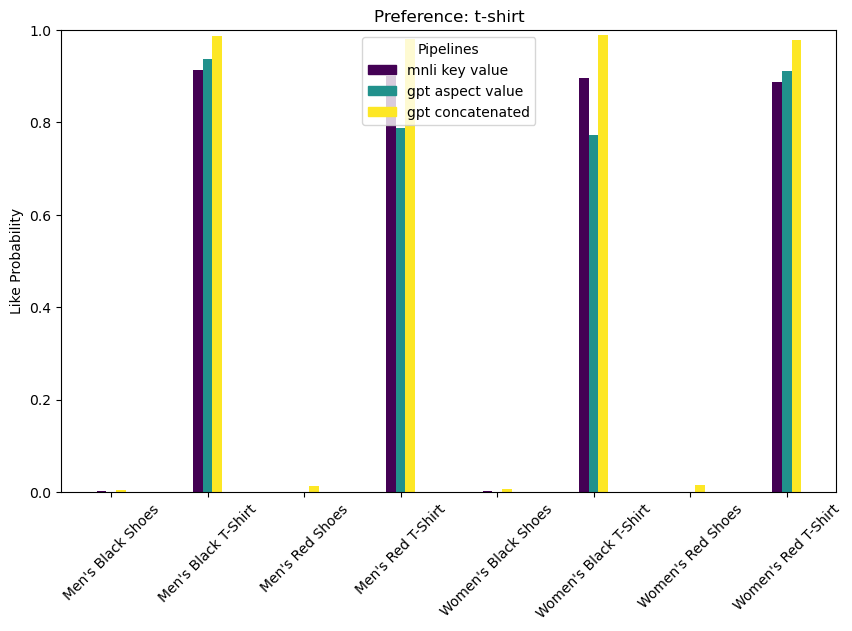

{'True': -0.3497122, 'False': -1.2225282}
{'False': -0.051889803, 'True': -3.0154634}
{'False': -0.32939693, 'True': -1.2756937}
{'False': -0.074789874, 'True': -2.6397083}
{'False': -0.23210968, 'True': -1.5754515}
{'False': -0.019537603, 'True': -4.012278}
{'False': -0.31307083, 'True': -1.3170896}
{'False': -0.040707603, 'True': -3.2570238}
{'False': -0.034350645, 'True': -3.422149}
{'False': -0.0021221882, 'True': -6.3285003}
{'False': -0.008595427, 'True': -4.8296804}
{'False': -0.0028849987, 'True': -6.1490526}
{'False': -0.0015754484, 'True': -6.9864616}
{'False': -0.0015218838, 'True': -6.595724}
{'False': -0.003949575, 'True': -6.0297885}
{'False': -0.002797868, 'True': -6.683405}


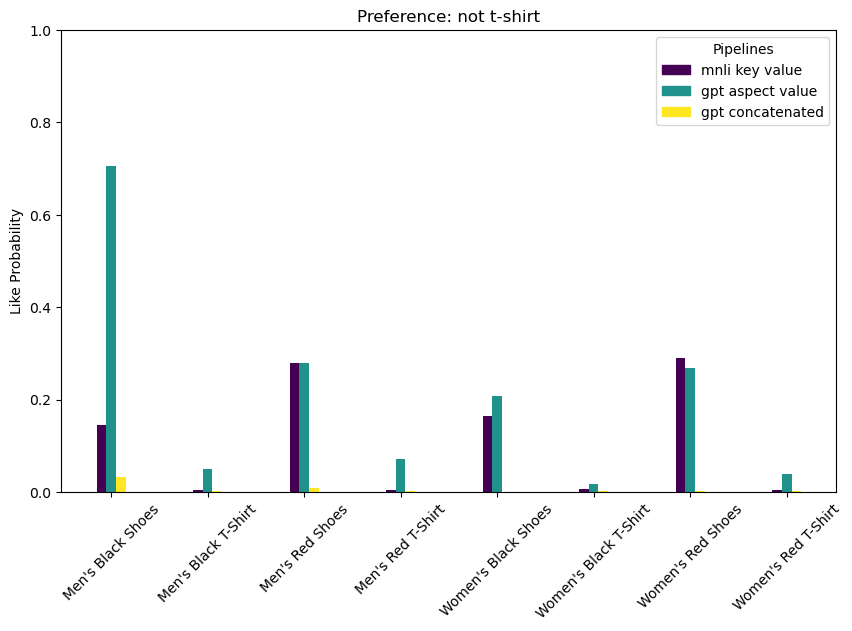

In [23]:
plot_entailment_pipeline(pipelines, easy_clothing_type_interactions, clothing)

{'True': -0.024562735, 'False': -3.8027554}
{'True': -0.019572916, 'False': -4.0740256}
{'True': -0.08603999, 'False': -2.5036883}
{'True': -0.12415701, 'False': -2.161127}
{'False': -0.0031563304, 'Your': -6.1970897}
{'False': -0.0030297635, 'Your': -6.234353}
{'False': -0.0018066724, 'True': -6.5768895}
{'False': -0.003216215, 'Your': -6.1024003}
{'True': -0.05590694, 'False': -2.9176567}
{'True': -0.013572161, 'False': -4.314773}
{'True': -0.052156433, 'False': -2.9858894}
{'True': -0.032705277, 'False': -3.4415092}
{'False': -0.0040287687, 'True': -5.892777}
{'False': -0.0021117167, 'True': -6.5007463}
{'False': -0.0016668501, 'True': -6.781172}
{'False': -0.002266709, 'True': -6.4239016}


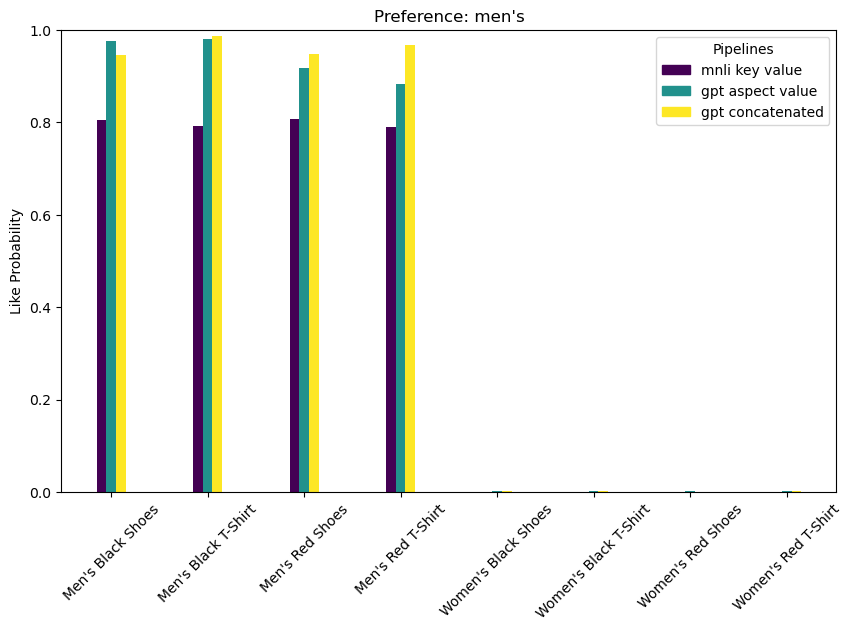

{'False': -0.0027251097, 'True': -6.450233}
{'False': -0.0029665304, 'True': -6.0290723}
{'False': -0.0031193646, 'True': -5.917001}
{'False': -0.0031122342, 'Your': -6.517448}
{'True': -0.09807645, 'False': -2.3781304}
{'True': -0.01956005, 'False': -3.97744}
{'True': -0.1006416, 'False': -2.3485854}
{'True': -0.046467904, 'False': -3.101535}
{'False': -0.09722209, 'True': -2.382651}
{'False': -0.10693046, 'True': -2.2914817}
{'False': -0.23009926, 'True': -1.5828519}
{'False': -0.10772433, 'True': -2.2883713}
{'False': -0.11602085, 'True': -2.221154}
{'False': -0.09624693, 'True': -2.394356}
{'False': -0.038339242, 'True': -3.3058276}
{'False': -0.08235109, 'True': -2.544458}


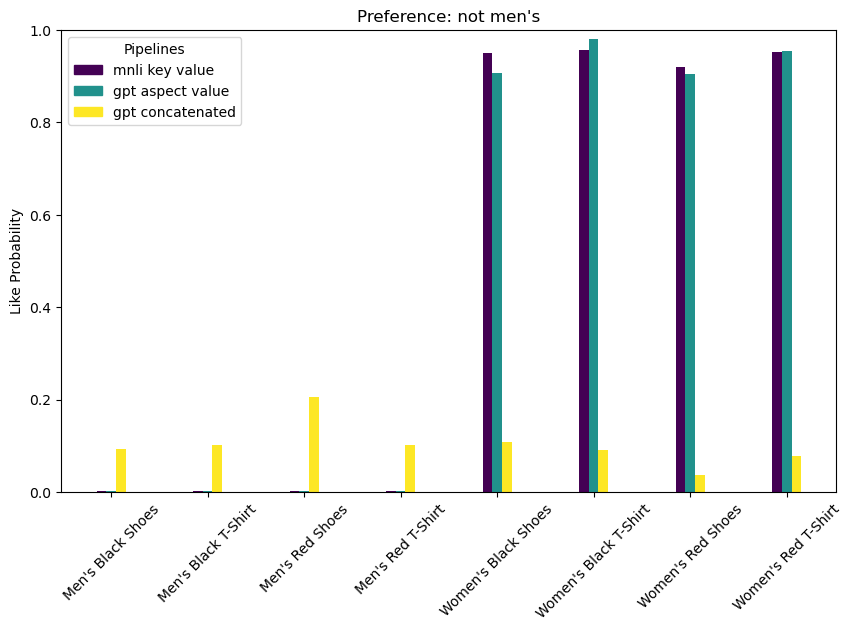

In [25]:
plot_entailment_pipeline(pipelines, easy_gender_interactions, clothing)

### FB mnli more experiments (neutral vs no neutral)


In [ ]:
hypotheses = ['not small red circle',
            'This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No',
            'Query:  Are you looking for a small red circle? \n Response:  No',
            'Men\'s blue shirt',
           'blue shirt',
             'blue',
             'Query: Are you looking for something blue? \nResponse: yes']
           
premises = ['large red circle', 'large red circle','large red circle','blue shirt','Men\'s blue shirt','Red Large Circle','Red Large Circle']

inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

# Ensure the tokenized inputs don't exceed the max length
if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
    print(f"Warning: One or more tokenized inputs exceed the max length of {max_length} and will be truncated.")

#no gpu use for notebook
#inputs = inputs.to(device)
    
with torch.no_grad():
    outputs = nli_model(**inputs)

#### Throwing away neutral:


In [ ]:
# as per: https://huggingface.co/facebook/bart-large-mnli
# throw away "neutral" (dim 1) and take the probability of
# "entailment" (2) as the probability of the label being true
entail_contr_logits = outputs[0][:,[0,2]]
entail_contr_probs  = torch.nn.functional.softmax(entail_contr_logits, dim=-1)

#entailment_probs = predictions[:, 2].tolist()
entail_contr_probs

#### Keeping neutral:


In [ ]:
all_probs = torch.nn.functional.softmax(outputs[0],dim=-1)
all_probs

In [ ]:
#Anton observation dec 12:
#logits are [contradicts, neutral, entails]

#Aspect negation format works OK
#-------------------------------
#premise = 'not small red circle'
#hypothesis = '''
#large red circle'''
#logits: [-0.8607, -0.2254,  1.5746]

#Raw query response format works bad
#-------------------------------
#premise = 'large red circle'
#hypothesis = '''
#This item would be liked by someone who responed as follows:
#Query:  Are you looking for a small red circle? \n Response:  No'''
#[ 2.7382, -1.1287, -2.2011]
#Anton observation Dec 12: neutral may only be output when the hypothesis is a generalization of the premise (e.g. P = soccer, H = world cup soccer)

#### Sentence-Transformer Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [72]:
test_CE_input =  [('not small red circle', 'large red circle'),
                  ('This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No','large red circle'),
                  ('Query:  Are you looking for a small red circle? \n Response:  No', 'large red circle'),
                  ('Men\'s blue shirt', 'blue shirt'),
                 ('blue shirt', 'Men\'s blue shirt'),
                 ('Blue Large Circle','not blue')]

output = ce_model.predict(test_CE_input)

torch.sigmoid(torch.from_numpy(output)).tolist()

[0.9460662007331848,
 6.547756493091583e-05,
 0.9145389795303345,
 0.728950560092926,
 0.9942330718040466,
 0.01334536261856556]

## Multiple Aspects

In [28]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
compound_color_gender_interactions = {
'black men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response': 'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
}

{'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }
{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' }

compound_type_color_interactions = {
't-shirt black' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'}],
't-shirt not black' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}],
'not t-shirt black' : [{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'}],
'not t-shirt not black ' :[{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}],
}

compound_color_type_gender_interactions = {
'black t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
}


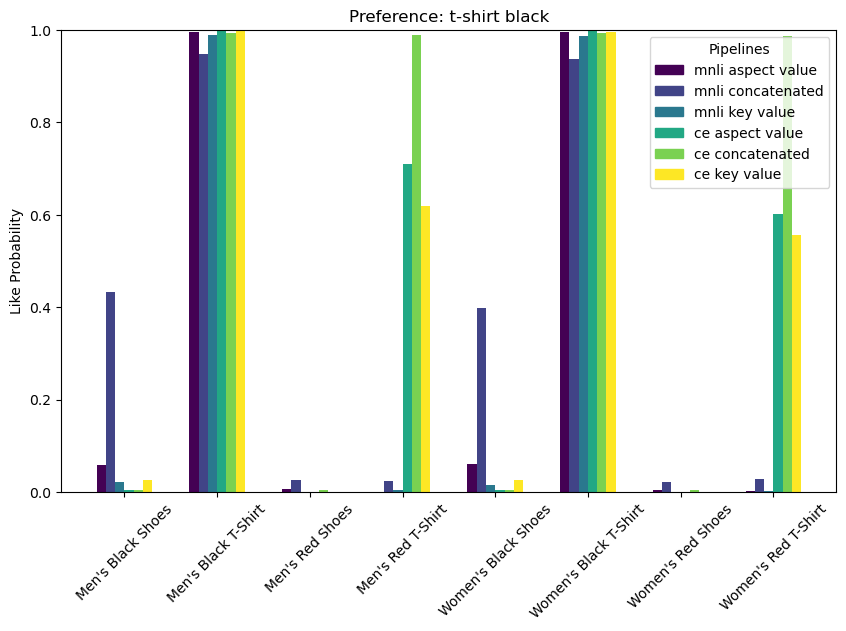

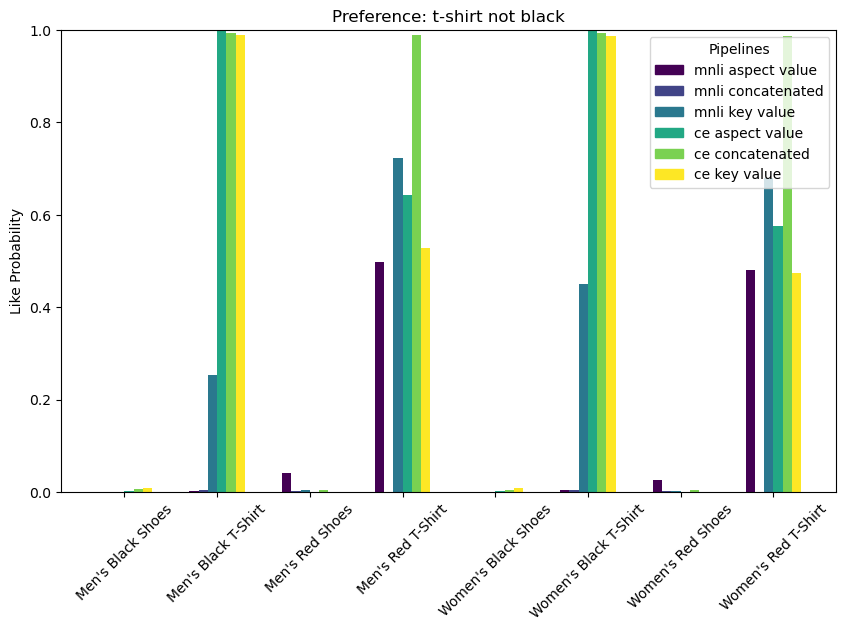

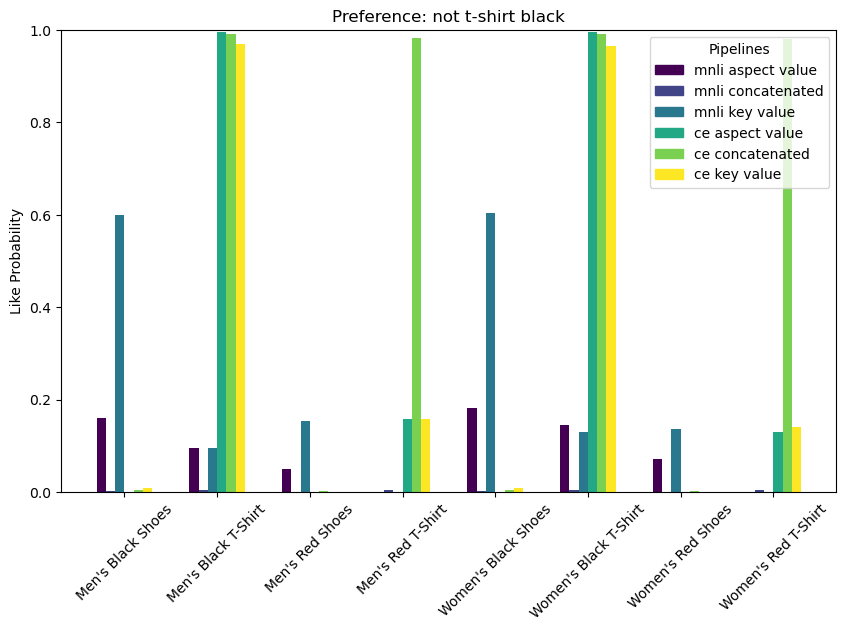

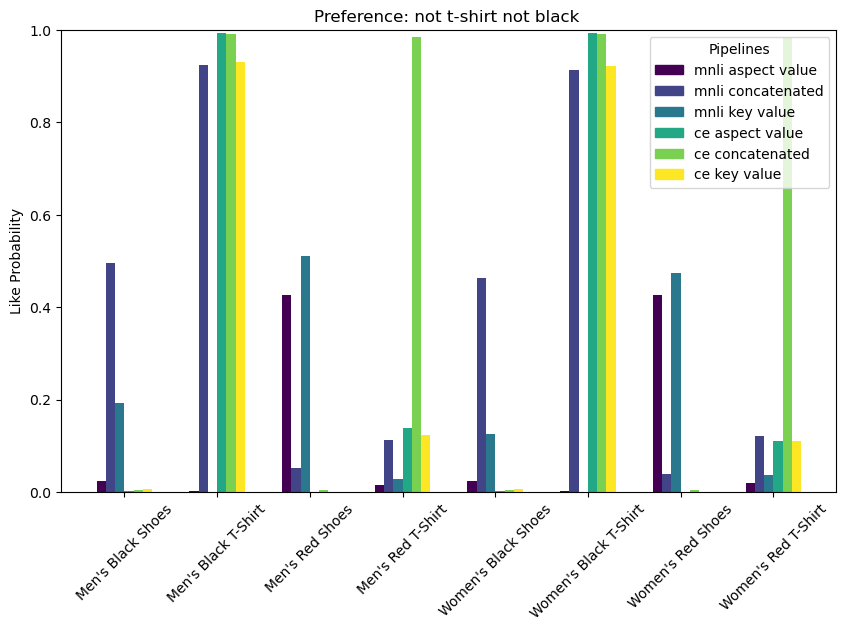

In [30]:
plot_entailment_pipeline(pipelines, compound_type_color_interactions, clothing)

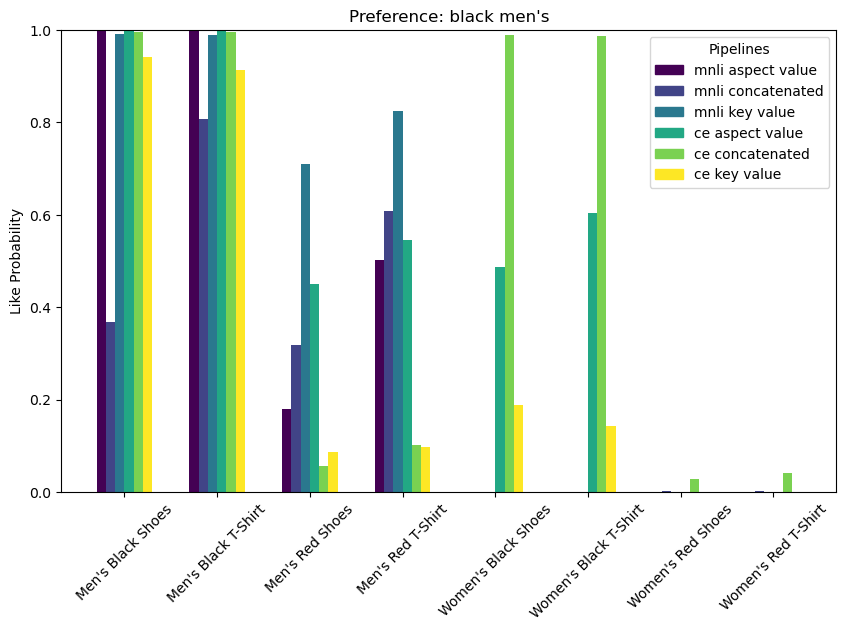

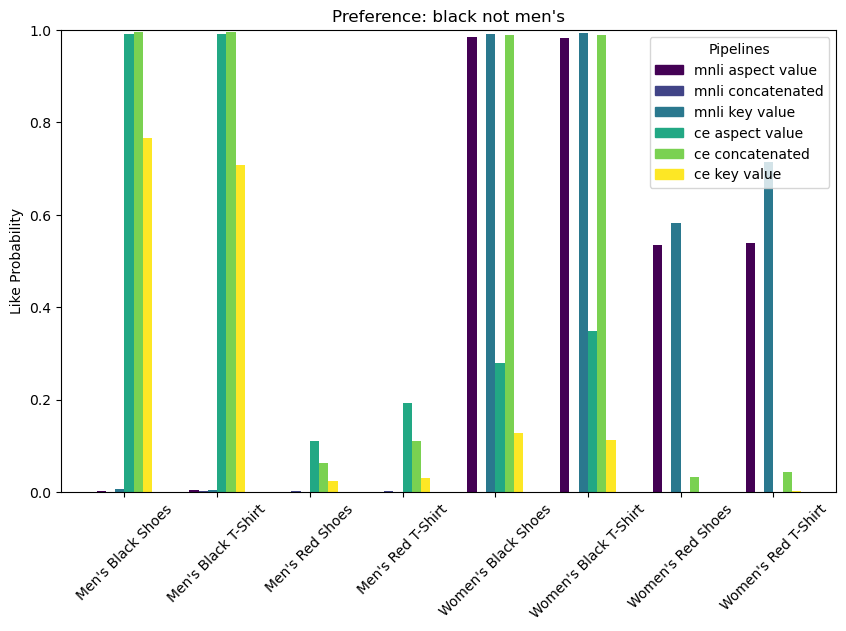

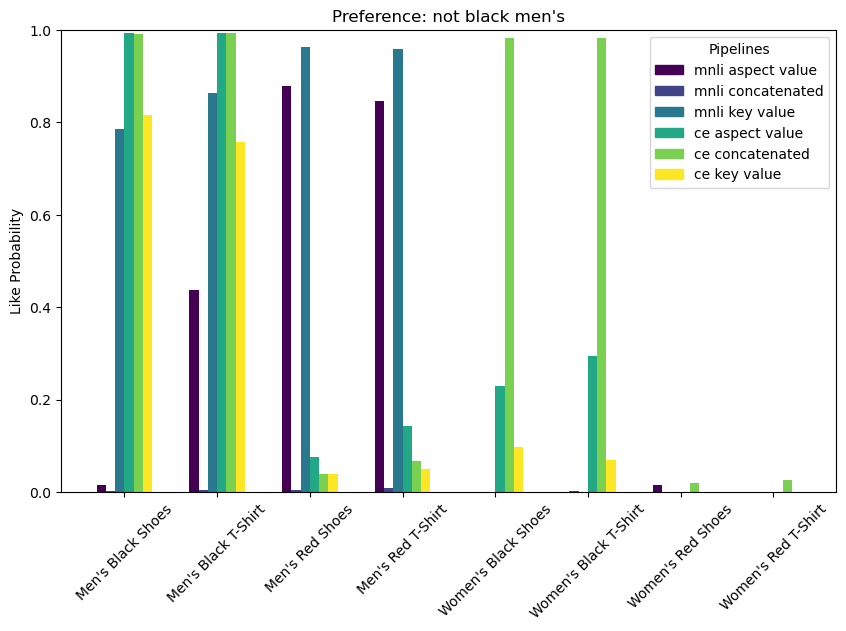

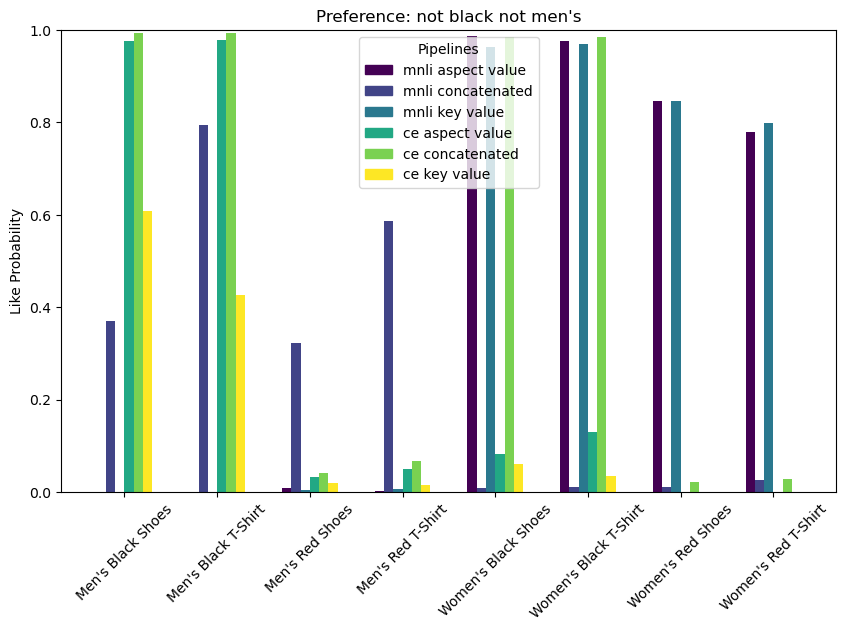

In [31]:
plot_entailment_pipeline(pipelines, compound_color_gender_interactions, clothing)

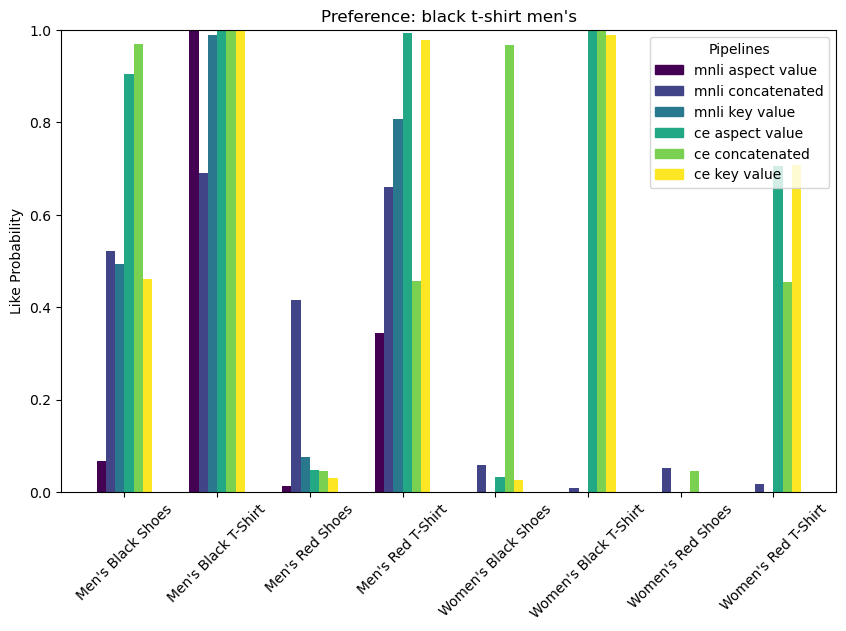

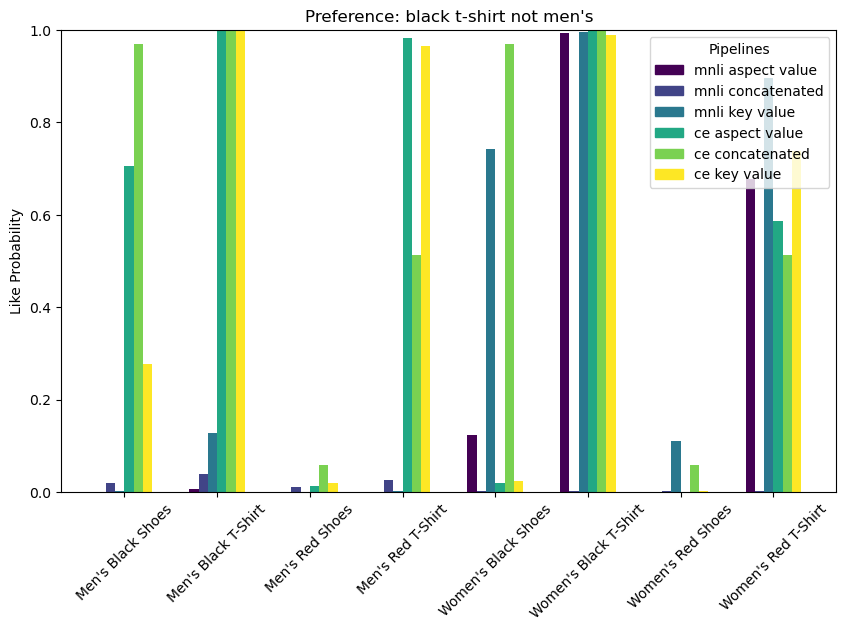

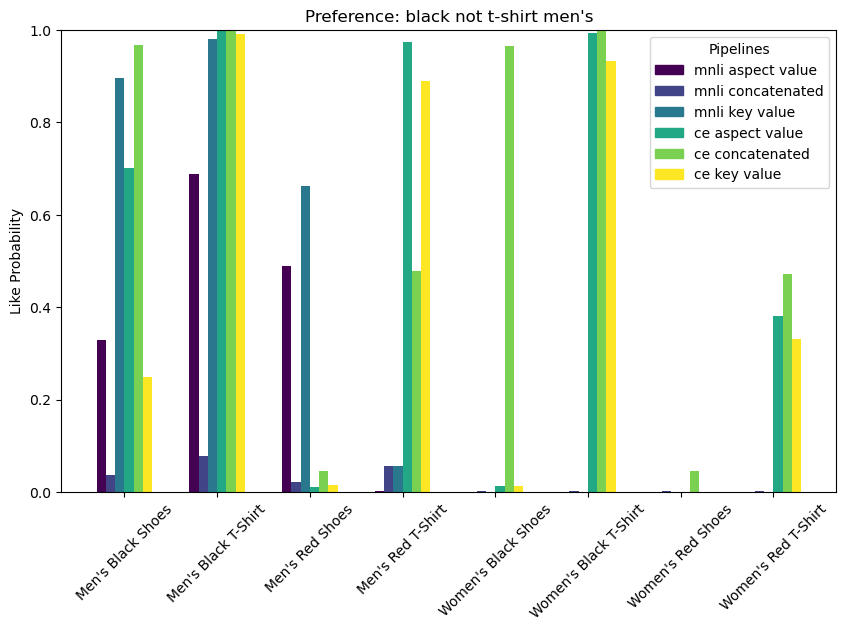

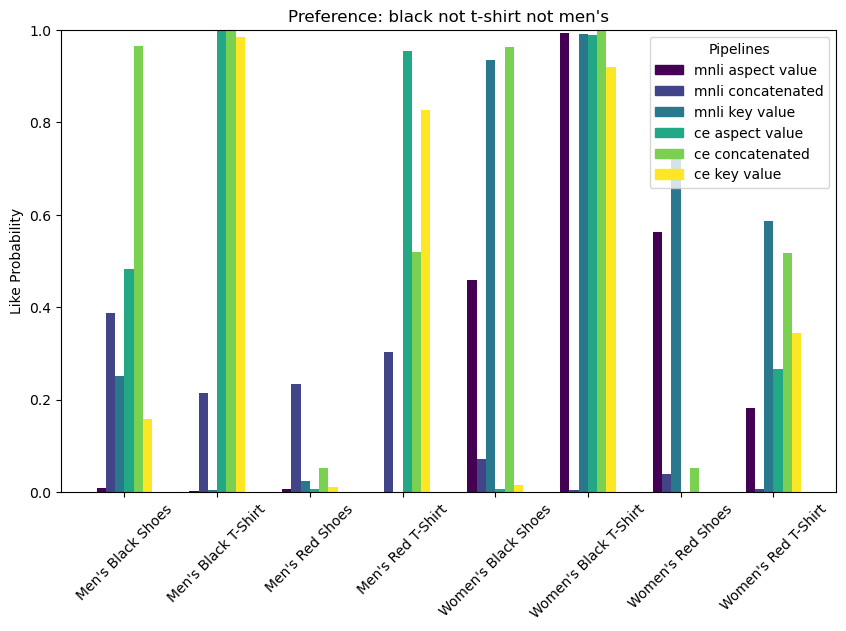

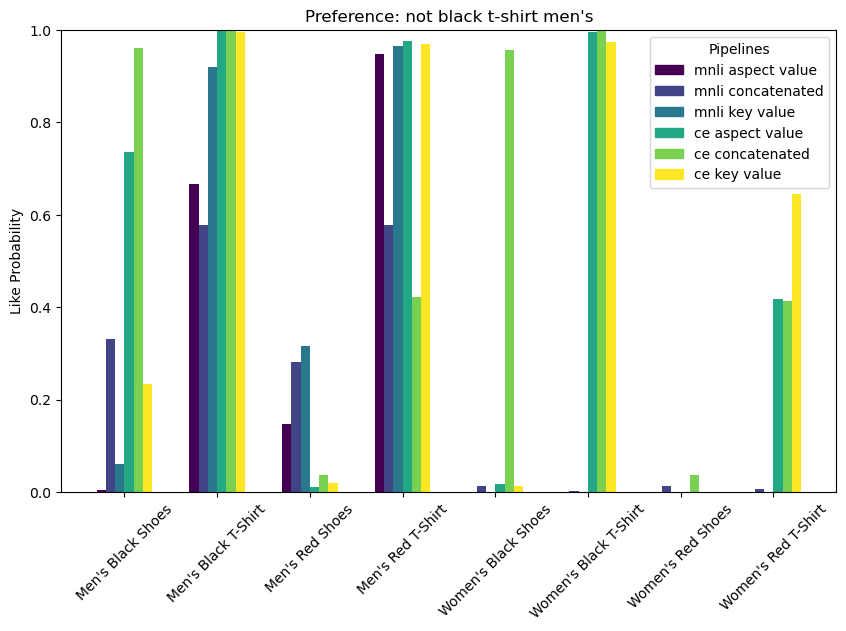

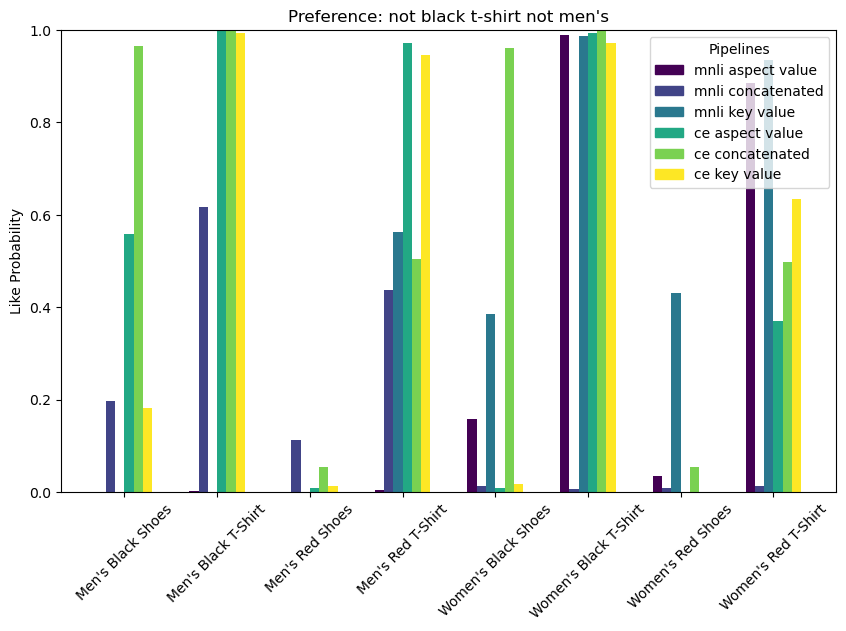

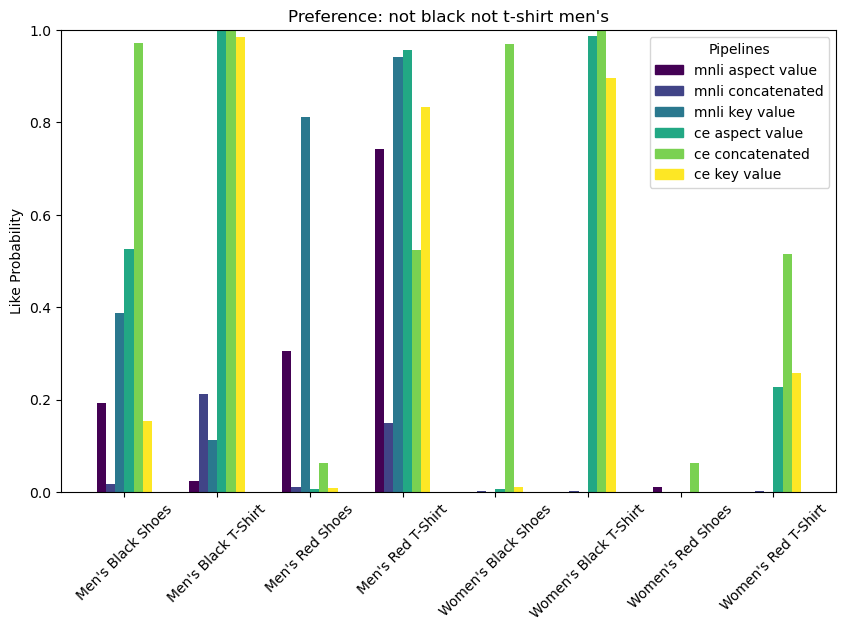

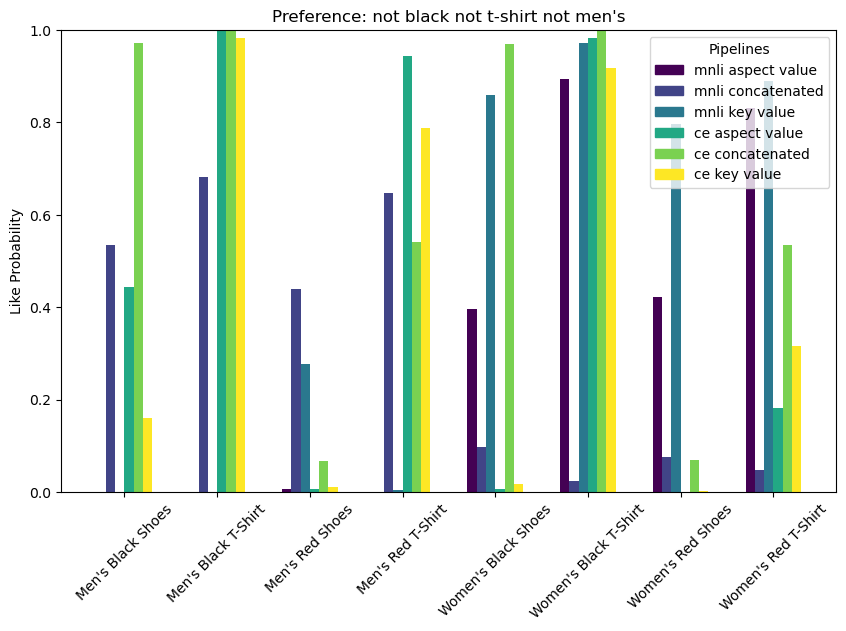

In [33]:
plot_entailment_pipeline(pipelines, compound_color_type_gender_interactions, clothing)

## MovieLens Testing

In [20]:
# Load in items
with open('data/movielens_2.json') as f:
    movies = json.load(f)
movies

{'1214': {'description': 'Horror, Sci-Fi, imdb top 250, aliens, sci-fi, suspense, thriller, tense, horror, atmospheric, outer space, space, space travel, suspenseful',
  'name': 'Alien (1979)'},
 '1240': {'description': 'Action, Sci-Fi, Thriller, Action, artificial intelligence, future, time travel, imdb top 250, arnold, Arnold Schwarzenegger, classic, cyborgs, dystopic future, highly quotable, robots',
  'name': 'Terminator, The (1984)'},
 '2571': {'description': 'Action, Sci-Fi, Thriller, alternate reality, artificial intelligence, cyberpunk, dystopia, philosophical, philosophy, sci-fi, virtual reality, Futuristic, post apocalyptic, surreal, thought-provoking',
  'name': 'Matrix, The (1999)'},
 '8874': {'description': 'Comedy, Horror, Simon Pegg, Very British and very funny!, zombies, black comedy, British, british comedy, comedy, dark comedy, dark humor, Edgar Wright, funny, hilarious',
  'name': 'Shaun of the Dead (2004)'},
 '46972': {'description': "Action, Comedy, Fantasy, IMAX, 

[0.00039183819899335504, 0.0016138498904183507, 0.001324314041994512, 0.9308335781097412, 0.4854845106601715, 0.9242262244224548, 0.5433396697044373, 0.001535077695734799]
[0.11323031783103943, 0.05345314368605614, 0.042395416647195816, 0.0006470502121374011, 0.0004352197574917227, 0.001177704893052578, 0.0013818073784932494, 0.06293465942144394]


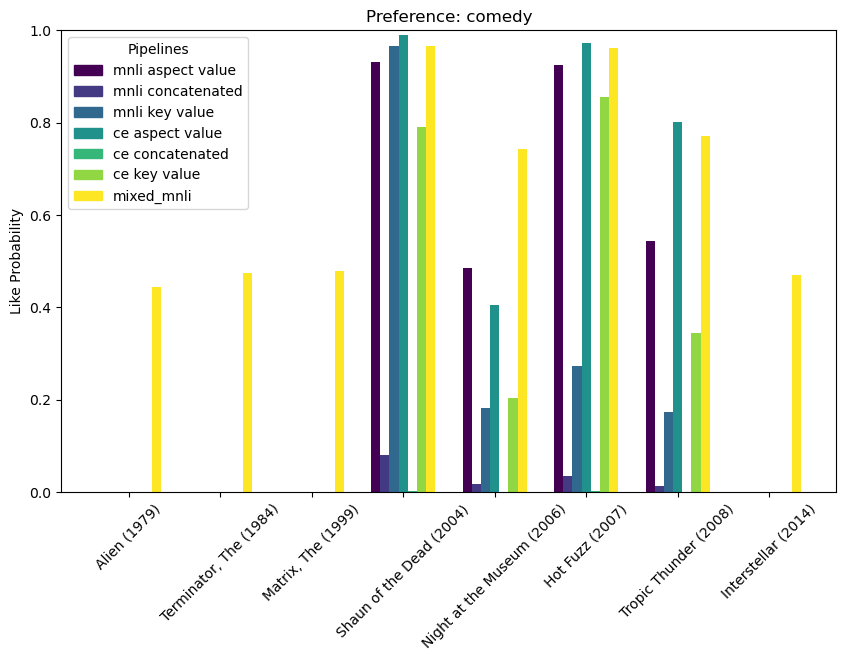

[0.00039183819899335504, 0.0016138498904183507, 0.001324314041994512, 0.9308335781097412, 0.4854845106601715, 0.9242262244224548, 0.5433396697044373, 0.001535077695734799]
[0.11323031783103943, 0.05345314368605614, 0.042395416647195816, 0.0006470502121374011, 0.0004352197574917227, 0.001177704893052578, 0.0013818073784932494, 0.06293465942144394]


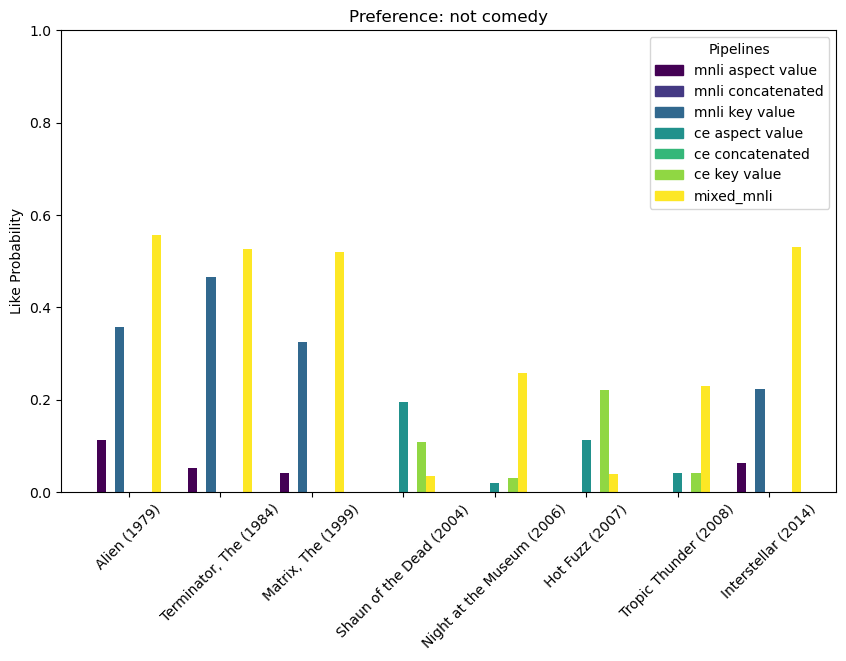

[0.978832483291626, 0.9594088792800903, 0.9525718688964844, 0.002040755469352007, 0.0008860400412231684, 0.0009784243302419782, 0.0011187928030267358, 0.969397783279419]
[0.0006327145965769887, 0.0007147922879084945, 0.0005267813103273511, 0.01450363826006651, 0.01290734950453043, 0.0031021570321172476, 0.0068790968507528305, 0.0005192140815779567]


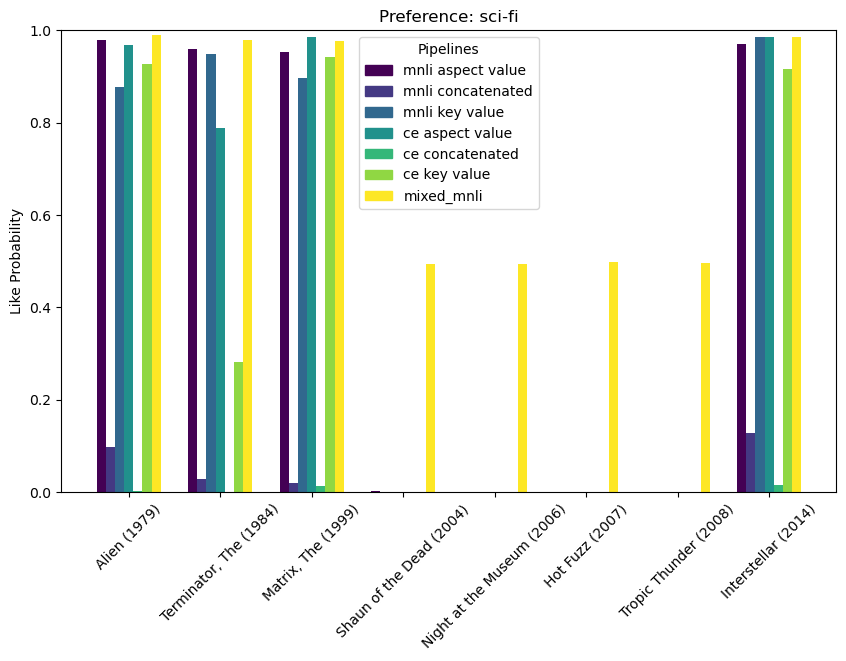

[0.978832483291626, 0.9594088792800903, 0.9525718688964844, 0.002040755469352007, 0.0008860400412231684, 0.0009784243302419782, 0.0011187928030267358, 0.969397783279419]
[0.0006327145965769887, 0.0007147922879084945, 0.0005267813103273511, 0.01450363826006651, 0.01290734950453043, 0.0031021570321172476, 0.0068790968507528305, 0.0005192140815779567]


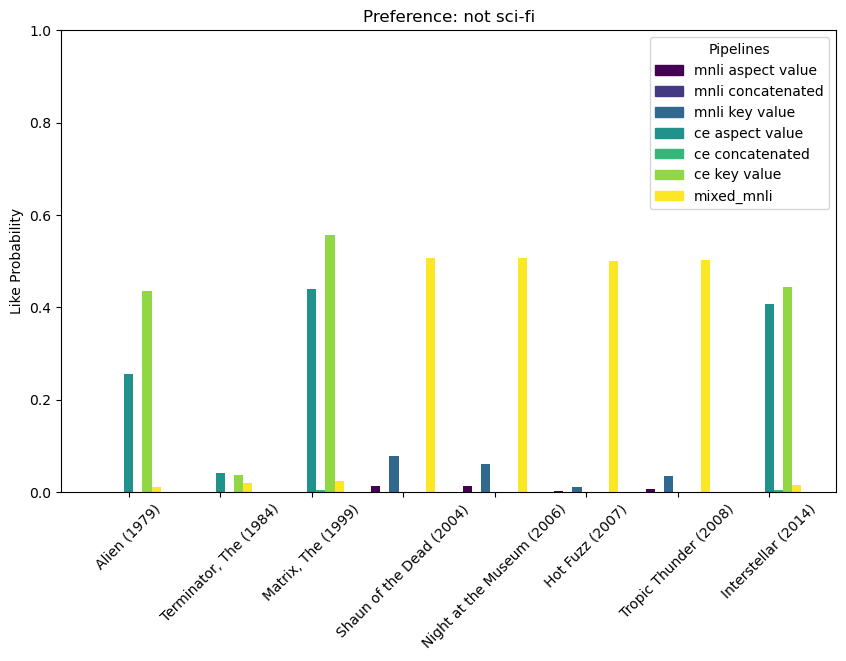

[0.030598318204283714, 0.04002697020769119, 0.08875007182359695, 0.013666628859937191, 0.0818881019949913, 0.02033006027340889, 0.024731723591685295, 0.11414583772420883]
[0.022886184975504875, 0.027697106823325157, 0.009104704484343529, 0.052525293081998825, 0.006252038758248091, 0.012257895432412624, 0.002780703129246831, 0.01205915492027998]


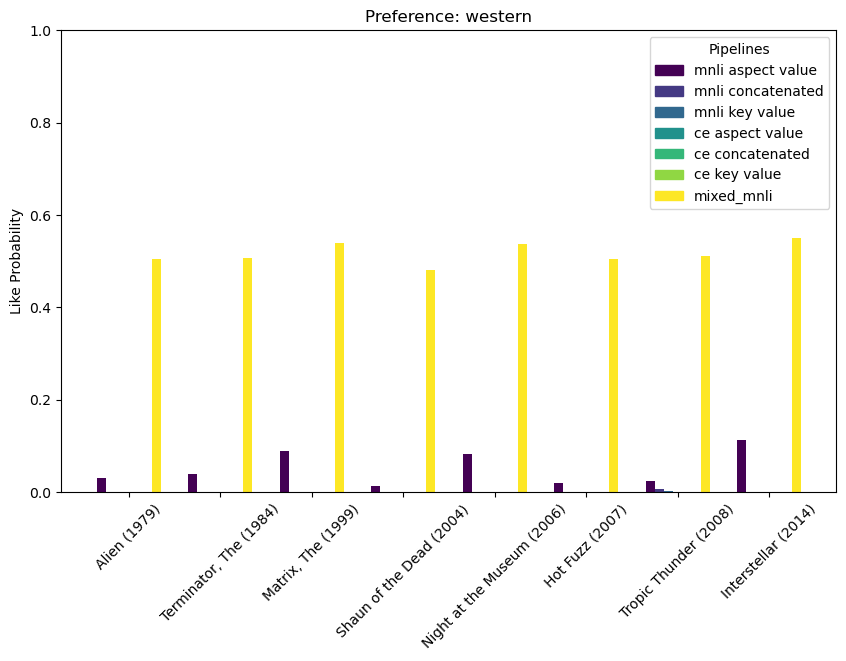

[0.030598318204283714, 0.04002697020769119, 0.08875007182359695, 0.013666628859937191, 0.0818881019949913, 0.02033006027340889, 0.024731723591685295, 0.11414583772420883]
[0.022886184975504875, 0.027697106823325157, 0.009104704484343529, 0.052525293081998825, 0.006252038758248091, 0.012257895432412624, 0.002780703129246831, 0.01205915492027998]


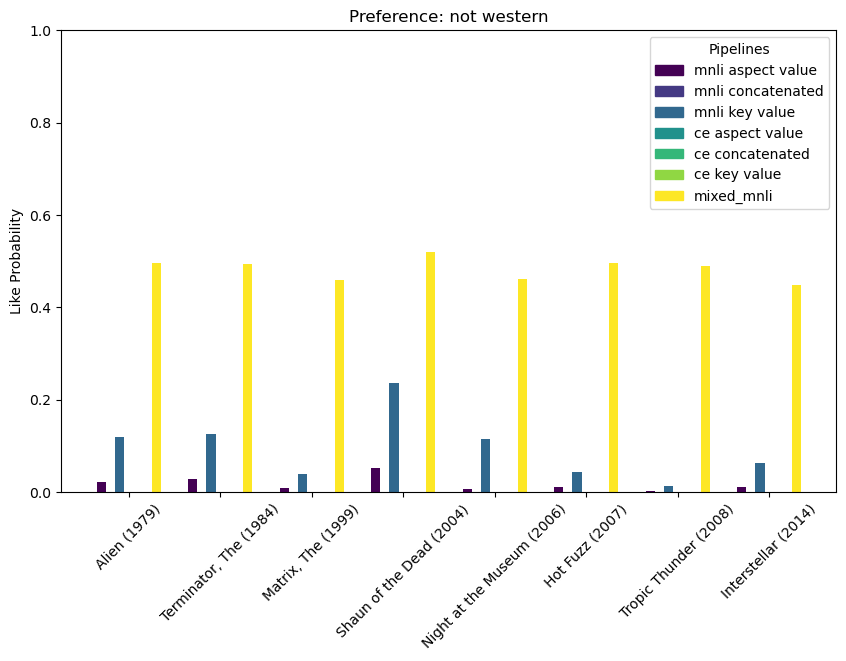

In [56]:
movie_genre_interactions = {
'comedy' : [{'query':'Do you like comedies?', 'response':'yes','aspect key': 'genre', 'aspect value': 'comedy' }],
'not comedy' : [{'query':'Do you like comedies?', 'response':'no','aspect key': 'genre', 'aspect value': 'comedy'}],
'sci-fi' : [{'query':'Do you like sci-fi?', 'response':'yes','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'not sci-fi' : [{'query':'Do you like sci-fi?', 'response':'no','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'western' : [{'query':'Do you like westerns?', 'response':'yes','aspect key': 'genre', 'aspect value': 'western' }],
'not western' : [{'query':'Do you like westerns?', 'response':'no','aspect key': 'genre', 'aspect value': 'western' }],
}

plot_entailment_pipeline(pipelines, movie_genre_interactions, movies)